<center><font size="4"><span style="color:blue">Demonstration 3: example of anomaly detection implementation</span></font></center>

This is a demonstration of the 3W dataset, the first realistic and public dataset with rare undesirable real events in oil wells as far as the authors of this work know. It can be used in development of several kinds of techniques and methods for different tasks associated with undesirable events in oil and gas wells.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering**.

**_Disclamer_**

_This notebook presents a demonstration. As we have not experienced all the possibilities, for example in terms of approaches, methods, parameter values, and metrics, we do not argue that the results presented here are optimal. However, these results can be used as initial benchmark for other works._

# 1. Introduction

This notebook presents an implementation of a specific task of interest (anomaly detection) applied to the 3W dataset. In this task, all types of undesirable events are grouped as anomalies. Thus, only two labels are considered, one for the positive class (normal instance) and another for the negative class (instance with anomaly).

# 2. Imports and Configurations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import logging
import warnings
from matplotlib import pyplot as plt
from time import time
from pathlib import Path
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import MinimalFCParameters
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support

In [2]:
logging.getLogger('tsfresh').setLevel(logging.ERROR)
warnings.simplefilter(action='ignore')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
data_path = Path('..', 'data')
clfs = {'OneClassSVM-RBF':     OneClassSVM(kernel='rbf', gamma='scale', nu=0.9),
        'OneClassSVM-SIGMOID': OneClassSVM(kernel='sigmoid', gamma='scale', nu=0.9),
        'OneClassSVM-POLY':    OneClassSVM(kernel='poly', gamma='scale', nu=0.9),
        'OneClassSVM-LINEAR':  OneClassSVM(kernel='linear', gamma='scale', nu=0.9),
        'IsolationForest':     IsolationForest(n_jobs=None, behaviour='new', 
                                               contamination=0, random_state=1)
        }
events_names = {0: 'Normal',
                1: 'Abrupt Increase of BSW',
                2: 'Spurious Closure of DHSV',
                3: 'Severe Slugging',
                4: 'Flow Instability',
                5: 'Rapid Productivity Loss',
                6: 'Quick Restriction in PCK',
                7: 'Scaling in PCK',
                8: 'Hydrate in Production Line'
               }
vars = ['P-PDG',
        'P-TPT',
        'T-TPT',
        'P-MON-CKP',
        'T-JUS-CKP',
        'P-JUS-CKGL',
        'T-JUS-CKGL',
        'QGL']
columns = ['timestamp'] + vars + ['class'] 
normal_class_code = 0
sample_size = 2*60              # In seconds = observations
min_normal_period_size = 10*60  # In seconds = observations
split_range = 0.6               # Train size/test size
max_samples_per_period = 100    # Limitation for safety
df_fc_p = MinimalFCParameters() # See tsfresh's documentation
disable_progressbar = True      # Less output

# 3. Anomaly Detection Implementation

The following cells implement a method for anomaly detection. The more relevant choices of this method are:

1. Only real instances with undesirable events are used. The specialists consider that the normality suffers with concept drift. As we don't need to learn the concept drift itself, this method supposes that a dedicated model for each well is trained from time to time;
1. Only instances with enough normal period are used. An initial part of each normal period is used in the training;
1. A specific sampling strategy is used for each type of period. In normal periods, the last observations are privileged. In periods in regime, it is sought to use observations throughout the regime as a whole. In normal periods, the first observations are privileged;
1. For each instance, the variables that remain frozen in the training samples are not used;
1. Before feature extraction the used variables are normalized with z-score;
1. For the sake of execution time, it is used the minimal set of features of the tsfresh package;
1. Five classifiers are evaluated (without parameters optimization).

In [5]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [6]:
def load_instance(instance_path):
    try:
        well, instance_id = instance_path.stem.split('_')
        df = pd.read_csv(instance_path, sep=',', header=0)
        assert (df.columns == columns).all(), 'invalid columns in the file {}: {}'\
            .format(str(instance_path), str(df.columns.tolist()))
        return df
    except Exception as e:
        raise Exception('error reading file {}: {}'.format(instance_path, e))

In [7]:
def extract_samples(df, class_code):
    # Gets the observations labels and their unequivocal set
    ols = list(df['class'])
    set_ols = set()
    for ol in ols:
        if ol in set_ols or np.isnan(ol):
            continue
        set_ols.add(int(ol))
    
    # Discards the observations labels and replaces all nan with 0 
    # (tsfresh's requirement)
    df_vars = df.drop('class', axis=1).fillna(0)            
    
    # Initializes objects that will be return
    df_samples_train = pd.DataFrame()
    df_samples_test = pd.DataFrame()
    y_train = []
    y_test = []

    # Extracts samples from the normal period for training and for testing
    #
    # Gets indexes (first and last) without overlap with other periods
    f_idx = ols.index(normal_class_code)
    l_idx = len(ols)-1-ols[::-1].index(normal_class_code)

    # Defines the proper step and extracts samples
    max_samples = l_idx-f_idx+1-sample_size+1
    if (max_samples) > 0:  
      num_samples = min(max_samples_per_period, max_samples)
      if num_samples == max_samples:
        step_max = 1 
      else:
        step_max = (max_samples-1) // (max_samples_per_period-1)
      step_wanted = sample_size
      step = min(step_wanted, step_max)

      # Extracts samples for training
      num_train_samples = int(split_range*num_samples)
      sample_id = 0
      for idx in range(num_train_samples):
        f_idx_c = l_idx-sample_size+1-(num_samples-1-idx)*step
        l_idx_c = f_idx_c+sample_size
        #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
        df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
        df_sample.insert(loc=0, column='id', value=sample_id)
        df_samples_train = df_samples_train.append(df_sample)
        y_train.append(normal_class_code)
        sample_id += 1
    
      # Extracts samples for testing
      num_test_samples = num_samples - num_train_samples
      sample_id = 0
      for idx in range(num_train_samples, num_train_samples+num_test_samples):
        f_idx_c = l_idx-sample_size+1-(num_samples-1-idx)*step
        l_idx_c = f_idx_c+sample_size
        #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
        df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
        df_sample.insert(loc=0, column='id', value=sample_id)
        df_samples_test = df_samples_test.append(df_sample)
        y_test.append(normal_class_code)
        sample_id += 1 

    # Extracts samples from the transient period (if it exists) for testing
    #
    transient_code = class_code + 100
    if transient_code in set_ols:
      # Gets indexes (first and last) with possible overlap at the beginning 
      # of this period
      f_idx = ols.index(transient_code)
      if f_idx-(sample_size-1) > 0:
        f_idx = f_idx-(sample_size-1)
      else:
        f_idx = 0
      l_idx = len(ols)-1-ols[::-1].index(transient_code)        

      # Defines the proper step and extracts samples
      max_samples = l_idx-f_idx+1-sample_size+1
      if (max_samples) > 0:
        num_samples = min(max_samples_per_period, max_samples)
        if num_samples == max_samples:
          step_max = 1 
        else:
          step_max = (max_samples-1) // (max_samples_per_period-1)
        step_wanted = np.inf
        step = min(step_wanted, step_max)
    
        # Extracts samples for testing
        for idx in range(num_samples):
          f_idx_c = f_idx+idx*step
          l_idx_c = f_idx_c+sample_size
          #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
          df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
          df_sample.insert(loc=0, column='id', value=sample_id)
          df_samples_test = df_samples_test.append(df_sample)
          y_test.append(transient_code)
          sample_id += 1
    
    # Extracts samples from the in regime period (if it exists) for testing 
    #
    if class_code in set_ols:
      # Gets indexes (first and last) with possible overlap at the beginning 
      # or end of this period
      f_idx = ols.index(class_code)
      if f_idx-(sample_size-1) > 0:
        f_idx = f_idx-(sample_size-1)
      else:
        f_idx = 0
      l_idx = len(ols)-1-ols[::-1].index(class_code)
      if l_idx+(sample_size-1) < len(ols)-1:
        l_idx = l_idx+(sample_size-1) 
      else:
        l_idx = len(ols)-1
  
      # Defines the proper step and extracts samples
      max_samples = l_idx-f_idx+1-sample_size+1
      if (max_samples) > 0 :
        num_samples = min(max_samples_per_period, max_samples)
        if num_samples == max_samples:
          step_max = 1 
        else:
          step_max = (max_samples-1) // (max_samples_per_period-1)
        step_wanted = sample_size
        step = min(step_wanted, step_max)
    
        # Extracts samples for testing
        for idx in range(num_samples):
          f_idx_c = f_idx+idx*step
          l_idx_c = f_idx_c+sample_size
          #print('{}-{}-{}'.format(idx, f_idx_c, l_idx_c))
          df_sample = df_vars.iloc[f_idx_c:l_idx_c, :]
          df_sample.insert(loc=0, column='id', value=sample_id)
          df_samples_test = df_samples_test.append(df_sample)
          y_test.append(class_code)
          sample_id += 1

    # Adequation for tsfresh
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    # We want binary classification: 1 for inliers (positive class = normal instance) and
    # -1 for outliers (negative class = instance with anomaly) (sklearn's requirement)
    y_test[y_test!=normal_class_code] = -1
    y_test[y_test==normal_class_code] = 1
    
    return df_samples_train, y_train, df_samples_test, y_test            

In [8]:
def train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs):
    for clf_name, clf in clfs.items():
        try:
            # Train
            t0 = time()
            clf.fit(X_train)
            t_train = time() - t0
                
            # Test
            t0 = time()
            y_pred = clf.predict(X_test)
            t_test = time() - t0
            
            # Calculates the main scores
            ret = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            p, r, f1, _ = ret
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': p,
                                    'RECALL': r,
                                    'F1': f1,
                                    'TRAIN[s]': t_train, 
                                    'TEST[s]': t_test}, ignore_index=True)
        except:
            scores = scores.append({'CLASSIFIER': clf_name, 
                                    'PRECISION': np.nan,
                                    'RECALL': np.nan,
                                    'F1': np.nan,
                                    'TRAIN[s]': np.nan, 
                                    'TEST[s]': np.nan}, ignore_index=True)

    return scores

In [9]:
# Gets all real instances but maintains only those with undesirable events
real_instances = pd.DataFrame(class_and_file_generator(data_path, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0] != 0].reset_index(drop=True)

In [10]:
# For each real instance with undesirable event
scores = pd.DataFrame()
ignored_instances = 0
used_instances = 0
for i, row in real_instances.iterrows():
    class_code, instance_path = row
    print('instance {}: {}'.format(i+1, instance_path))
    df = load_instance(instance_path)
    
    # Ignores instances without sufficient normal periods
    normal_period_size = (df['class']==float(normal_class_code)).sum()
    if normal_period_size < min_normal_period_size:
        ignored_instances += 1
        print('\tnormal_period_size = {}. instance ignored = {}'.format(normal_period_size, 
                                                                        ignored_instances))
        continue
    used_instances += 1
        
    # Extracts samples from the current real instance
    df_samples_train, y_train, df_samples_test, y_test = extract_samples(df, class_code)
    
    # Discards vars that are frozen in training samples
    frozen_vars = []
    good_vars = []
    for var in vars:
        if len(df_samples_train[var].unique()) == 1:
            frozen_vars.append(var)
        else:
            good_vars.append(var)
    df_samples_train.drop(columns=frozen_vars, inplace=True, errors='ignore')
    df_samples_test.drop(columns=frozen_vars, inplace=True, errors='ignore')
    
    # Normalizes the samples (zero mean and unit variance)
    scaler = preprocessing.StandardScaler()
    df_samples_train[good_vars] = scaler.fit_transform(df_samples_train[good_vars])
    df_samples_test[good_vars] = scaler.transform(df_samples_test[good_vars])
    
    # Extracts features from samples
    X_train = extract_features(df_samples_train, 
                               column_id='id', 
                               column_sort='timestamp', 
                               default_fc_parameters=df_fc_p,
                               impute_function=impute,
                               n_jobs=0,
                               disable_progressbar=disable_progressbar)
    X_train = X_train.reset_index(drop=True)
    X_test = extract_features(df_samples_test, 
                              column_id='id', 
                              column_sort='timestamp',
                              default_fc_parameters=df_fc_p,
                              impute_function=impute,
                              n_jobs=0,
                              disable_progressbar=disable_progressbar)
    X_test = X_test.reset_index(drop=True)
    
    # Trains, tests and calculates the scores
    scores = train_test_calc_scores(X_train, y_train, X_test, y_test, scores, clfs)

instance 1: ../data/1/WELL-00001_20140124213136.csv
instance 2: ../data/1/WELL-00002_20140126200050.csv
instance 3: ../data/1/WELL-00006_20170801063614.csv
instance 4: ../data/1/WELL-00006_20170802123000.csv
instance 5: ../data/1/WELL-00006_20180618060245.csv
instance 6: ../data/2/WELL-00002_20131104014101.csv
instance 7: ../data/2/WELL-00003_20141122214325.csv
instance 8: ../data/2/WELL-00003_20170728150240.csv
instance 9: ../data/2/WELL-00003_20180206182917.csv
	normal_period_size = 586. instance ignored = 1
instance 10: ../data/2/WELL-00009_20170313160804.csv
instance 11: ../data/2/WELL-00010_20171218200131.csv
instance 12: ../data/2/WELL-00011_20140515110134.csv
instance 13: ../data/2/WELL-00011_20140530100015.csv
	normal_period_size = 482. instance ignored = 2
instance 14: ../data/2/WELL-00011_20140606230115.csv
instance 15: ../data/2/WELL-00011_20140720120102.csv
instance 16: ../data/2/WELL-00011_20140726180015.csv
instance 17: ../data/2/WELL-00011_20140824000118.csv
instance 18:

	normal_period_size = 0. instance ignored = 73
instance 99: ../data/4/WELL-00002_20131209050000.csv
	normal_period_size = 0. instance ignored = 74
instance 100: ../data/4/WELL-00002_20131209070000.csv
	normal_period_size = 0. instance ignored = 75
instance 101: ../data/4/WELL-00002_20131209090000.csv
	normal_period_size = 0. instance ignored = 76
instance 102: ../data/4/WELL-00002_20131209110000.csv
	normal_period_size = 0. instance ignored = 77
instance 103: ../data/4/WELL-00002_20131209130000.csv
	normal_period_size = 0. instance ignored = 78
instance 104: ../data/4/WELL-00002_20131212090000.csv
	normal_period_size = 0. instance ignored = 79
instance 105: ../data/4/WELL-00002_20131212110000.csv
	normal_period_size = 0. instance ignored = 80
instance 106: ../data/4/WELL-00002_20131214220010.csv
	normal_period_size = 0. instance ignored = 81
instance 107: ../data/4/WELL-00002_20131215000010.csv
	normal_period_size = 0. instance ignored = 82
instance 108: ../data/4/WELL-00002_2013121502

	normal_period_size = 0. instance ignored = 154
instance 180: ../data/4/WELL-00002_20140124080020.csv
	normal_period_size = 0. instance ignored = 155
instance 181: ../data/4/WELL-00002_20140124100054.csv
	normal_period_size = 0. instance ignored = 156
instance 182: ../data/4/WELL-00002_20140124120131.csv
	normal_period_size = 0. instance ignored = 157
instance 183: ../data/4/WELL-00002_20140124140041.csv
	normal_period_size = 0. instance ignored = 158
instance 184: ../data/4/WELL-00002_20140124160018.csv
	normal_period_size = 0. instance ignored = 159
instance 185: ../data/4/WELL-00002_20140124180136.csv
	normal_period_size = 0. instance ignored = 160
instance 186: ../data/4/WELL-00002_20140124200008.csv
	normal_period_size = 0. instance ignored = 161
instance 187: ../data/4/WELL-00002_20140124220029.csv
	normal_period_size = 0. instance ignored = 162
instance 188: ../data/4/WELL-00002_20140125000055.csv
	normal_period_size = 0. instance ignored = 163
instance 189: ../data/4/WELL-00002

	normal_period_size = 0. instance ignored = 239
instance 265: ../data/4/WELL-00005_20170625060103.csv
	normal_period_size = 0. instance ignored = 240
instance 266: ../data/4/WELL-00005_20170625093000.csv
	normal_period_size = 0. instance ignored = 241
instance 267: ../data/4/WELL-00005_20170625113000.csv
	normal_period_size = 0. instance ignored = 242
instance 268: ../data/4/WELL-00005_20170625133000.csv
	normal_period_size = 0. instance ignored = 243
instance 269: ../data/4/WELL-00005_20170626050116.csv
	normal_period_size = 0. instance ignored = 244
instance 270: ../data/4/WELL-00005_20170626070033.csv
	normal_period_size = 0. instance ignored = 245
instance 271: ../data/4/WELL-00005_20170626090055.csv
	normal_period_size = 0. instance ignored = 246
instance 272: ../data/4/WELL-00005_20170626110038.csv
	normal_period_size = 0. instance ignored = 247
instance 273: ../data/4/WELL-00005_20170626130016.csv
	normal_period_size = 0. instance ignored = 248
instance 274: ../data/4/WELL-00005

	normal_period_size = 0. instance ignored = 321
instance 347: ../data/4/WELL-00010_20180425160107.csv
	normal_period_size = 0. instance ignored = 322
instance 348: ../data/4/WELL-00010_20180425180046.csv
	normal_period_size = 0. instance ignored = 323
instance 349: ../data/4/WELL-00010_20180425200116.csv
	normal_period_size = 0. instance ignored = 324
instance 350: ../data/4/WELL-00010_20180425220046.csv
	normal_period_size = 0. instance ignored = 325
instance 351: ../data/4/WELL-00010_20180426000124.csv
	normal_period_size = 0. instance ignored = 326
instance 352: ../data/4/WELL-00010_20180426020124.csv
	normal_period_size = 0. instance ignored = 327
instance 353: ../data/4/WELL-00010_20180426040033.csv
	normal_period_size = 0. instance ignored = 328
instance 354: ../data/4/WELL-00010_20180426060029.csv
	normal_period_size = 0. instance ignored = 329
instance 355: ../data/4/WELL-00010_20180426080025.csv
	normal_period_size = 0. instance ignored = 330
instance 356: ../data/4/WELL-00010

# 4. Results

The results obtained with the implemented method are presented below.

In [11]:
print('number of used instances: {}'.format(used_instances))
print('number of ignored instances: {}'.format(ignored_instances))

number of used instances: 44
number of ignored instances: 384


In [12]:
print('used features: {}'.format(list(df_fc_p.keys())))

used features: ['sum_values', 'median', 'mean', 'length', 'standard_deviation', 'variance', 'maximum', 'minimum']


# 4.1. Metrics in Tabular Format

The following tables present the averages and variances of the metrics, respectively. Both are ordered by F1 metric.

In [13]:
score_table = scores.groupby('CLASSIFIER').mean().sort_values(by=['F1'], ascending=False)
score_table

,F1,PRECISION,RECALL,TEST[s],TRAIN[s]
CLASSIFIER,,,,,
IsolationForest,0.720252,0.873699,0.688582,0.030037,0.087333
OneClassSVM-POLY,0.717905,0.774153,0.720685,0.000575,0.000721
OneClassSVM-LINEAR,0.452969,0.609536,0.435714,0.000599,0.014460
OneClassSVM-RBF,0.387715,0.370971,0.441775,0.000680,0.000882
OneClassSVM-SIGMOID,0.387577,0.351158,0.441667,0.000614,0.000798


In [14]:
scores.groupby('CLASSIFIER').var().sort_values(by=['F1'], ascending=False)

,F1,PRECISION,RECALL,TEST[s],TRAIN[s]
CLASSIFIER,,,,,
OneClassSVM-POLY,0.125890,0.119237,0.106596,2.044674e-08,3.714485e-09
OneClassSVM-SIGMOID,0.120486,0.101501,0.153693,2.433720e-08,5.395233e-08
OneClassSVM-RBF,0.119314,0.107141,0.152966,6.250179e-08,6.357060e-09
OneClassSVM-LINEAR,0.115773,0.160621,0.110669,2.297292e-08,2.300655e-03
IsolationForest,0.080588,0.061172,0.086934,6.648811e-06,8.641543e-06


# 4.2. Matrics in Boxplots

The boxplots presented below are ordered by the mean of the F1 metric.

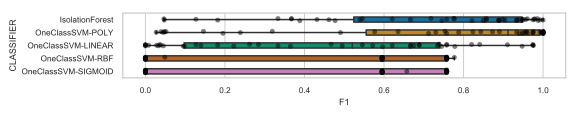

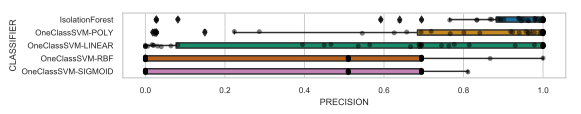

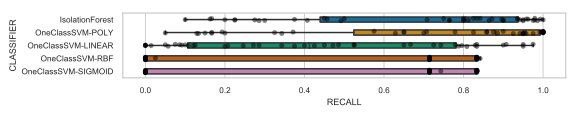

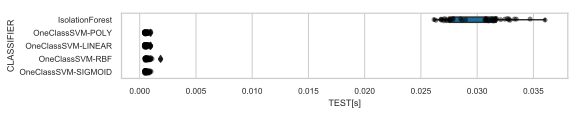

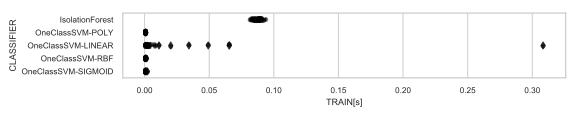

In [15]:
sns.set(font_scale=0.75, style="whitegrid")
for score in scores.columns.drop(['CLASSIFIER']):
    plt.figure(figsize=(8,1.2))
    bplot=sns.boxplot(y='CLASSIFIER', x=score, data=scores, width=0.4, 
                      palette='colorblind', order=list(score_table.index));
    bplot=sns.stripplot(y='CLASSIFIER', x=score, data=scores, jitter=True, marker='o', 
                        alpha=0.5, color='black', order=list(score_table.index))